In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for model evaluation and hyperparameter tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression

## Starting with loading and understanding the data.

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f"Shape of the training dataset : {train.shape}.\n")
train.head()

Shape of the training dataset : (13636, 15).



,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [4]:
train.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


From the desciption :
* any value other than 1 for UserReputation seems to be an outlier. That is most of the users who made a review had a reputation of 1.
* for ReplyCount, ThumbsUpCount and ThumbsDownCount any value other than 0 is an outlier. That is most of the comments had no reply and no votes.

In [5]:
train.nunique()

ID                     701
RecipeNumber           100
RecipeCode             100
RecipeName             100
CommentID            13636
UserID               10783
UserName             10620
UserReputation          20
CreationTimestamp     2422
ReplyCount               4
ThumbsUpCount           57
ThumbsDownCount         51
Rating                   6
BestScore              525
Recipe_Review        13370
dtype: int64

## Initial insights
* Column ID has 701 unique values. ID's should not repeat as they are unique vallues assigned for identification.
* RecipeNumber, RecipeCode and RecipeName all denote eachother.
* CommentID has 13636 unique samples. Hence we are given comments for different food recipies by different users.
* UserID and UserName has 10783 and 10620 unique samples respectively. But they should be equal because UserID and UserName are unique for each user.
* UserReputation has only 20 unique samples. hence most users has some specific reputation from those 20 unique ones. Also a user's reputation would not help to determine the rating.
* CreationTimestamp can be removed since clearly when a comment was made donot help to determine its rating.
* ReplyCount has 4 unique samples, which also can be removed since the number of replys do not determine the rating.
* ThumbsUpCount, ThumbsDownCount and best score is just a measure of the comment and does not involve in predicting the recipe rating.
* Recipe_Review has 13370 unique samples out of 13636 samples which means some reviews have been repeating which is normal.


* #### Amoung all only 'Recipe_Review' and 'Recipe_Code' contribute the best in predicting the rating.

In [6]:
print(f"ThumbsUpCount : \n\n{train['ThumbsUpCount'].unique()}\n")
print(f"ThumbsDownCount : \n\n{train['ThumbsDownCount'].unique()}\n")
print(f"ReplyCount : \n\n{train['ReplyCount'].unique()}\n")

ThumbsUpCount : 

[ 0  1  3  2 23  5 36  4  8 31 10 20  7  6 12 18  9 22 13 11 15 32 26 16
 76 19 44 35 45 29 55 42 14 27 41 37 30 21 24 17 33 40 28 25 73 39 57 80
 69 43 47 79 46 50 68 34 48]

ThumbsDownCount : 

[  0   1  10  29   6   3   5   9   2   4  17   8  13  11   7  12  15  19
  78  26  21  41  16  40  62  31  55  14  24  20  71  25  49  37  39  18
  65  32 126  63  46  30  23 104  42  70  22  87  27  61  38]

ReplyCount : 

[0 1 2 3]



* The values or some amoung the values seen above are repeating too many times considering the total sample which is not a normal behavior.

In [11]:
train['Rating'].unique()


array([5, 3, 4, 0, 2, 1])

#### Rating being the target column has 6 unique values which range from 0 - 5. These are the classes for the Multiclass Classification Model.

In [12]:
train.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

* There appears to be two null values in the column Recipe_Review

In [20]:
recipes = train['RecipeName'].unique()
recipes

array(['Banana Bars with Cream Cheese Frosting', 'Simple Taco Soup',
       'Cheeseburger Soup', 'Grilled Huli Huli Chicken',
       'Cauliflower Soup', 'Favorite Chicken Potpie',
       'Fluffy Key Lime Pie', 'Seafood Lasagna', 'Cheesy Ham Chowder',
       'First-Place Coconut Macaroons', 'Rhubarb Custard Bars',
       'Garlic Beef Enchiladas', 'Pork Chops with Scalloped Potatoes',
       'Peanut Butter Cup Cheesecake', 'Li’l Cheddar Meat Loaves',
       'Chicken Wild Rice Soup', 'Flavorful Chicken Fajitas',
       'Enchilada Casser-Ole!', 'Creamy White Chili',
       'Stuffed Pepper Soup', 'Lemon Blueberry Bread',
       'Chicken and Dumplings', 'Porcupine Meatballs',
       'Simple Au Gratin Potatoes', 'Basic Homemade Bread',
       'Zucchini Cupcake', 'Forgotten Jambalaya', 'Ravioli Lasagna',
       'Contest-Winning New England Clam Chowder', 'Basic Banana Muffins',
       'Creamy Grape Salad', 'Big Soft Ginger Cookies',
       'Pumpkin Spice Cupcakes with Cream Cheese Frosting',
 

In [42]:
X = train[['RecipeName','Recipe_Review']]
Y = train['Rating']
print(X.shape)
X.head()

(13636, 2)


,RecipeName,Recipe_Review
0,Banana Bars with Cream Cheese Frosting,great recipe! I have made them just as written...
1,Simple Taco Soup,This is an easy and quick recipe that is great...
2,Cheeseburger Soup,I think I was looking for something extra spec...
3,Grilled Huli Huli Chicken,This is our favorite grilled chicken recipe. ...
4,Cauliflower Soup,Great basic recipe. I added 2 teaspoons Tuscan...


In [59]:
from sklearn.model_selection import train_test_split

trainx, testx, trainy, testy = train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=420)
print(f"\n{trainx.shape}, {testx.shape}, {trainy.shape}, {testy.shape}")


(10908, 2), (2728, 2), (10908,), (2728,)


In [60]:
trainx.head()

,RecipeName,Recipe_Review
9353,Blueberry French Toast,Either something went terribly wrong (could be...
10884,Zucchini Cupcake,I made &#34;mini&#34; cupcakes for my husband ...
1618,Enchilada Casser-Ole!,I like this recipe but I used shredded chicken...
1541,Rhubarb Custard Bars,These bars are winners! I substituted Cool Whi...
2319,Cauliflower Soup,I just made this soup and it is absolutely del...


# Preprocessing

In [61]:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy='most_frequent')

# trainx = si.fit_transform(trainx.values.reshape(-1,1))[:,0]
# testx = si.fit_transform(testx.values.reshape(-1,1))[:,0]
trainx = si.fit_transform(trainx['Recipe_Review'].values.reshape(-1,1))[:,0]
testx = si.fit_transform(testx['Recipe_Review'].values.reshape(-1,1))[:,0]

print("Imputation Complete")

Imputation Complete


In [62]:
# confirm that there are no null values
count = 0
for i in trainx:
    if i == np.nan:

    # if (i[0] == np.nan) or (i[1] == np.nan):
        count += 1
if count>0:
    print(f"There are null values in trainx\nTotal null values : {count}")
else:
    print("There are no null values in trainx")

There are no null values in trainx


### Feature Extraction
* Given text data in Recipe_Reviews
* convert text to numbers using feature extraction techniques

#### Using TfidfVectorizer since it takes into account both the freequency of words and its importance.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words_list = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'but', 'by', 'for', 'if', 'in', 'into', 'is', 'it', 'no', 'not', 'of', 'on', 'or', 'such', 'that', 'the', 'their', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'will', 'with']
vectorizer = TfidfVectorizer(stop_words=stop_words_list)

trainx = vectorizer.fit_transform(trainx)
testx = vectorizer.transform(testx)

print(f"trainx : {trainx.shape}\ntestx : {testx.shape}")

trainx : (10908, 9447)
testx : (2728, 9447)


In [66]:
features = vectorizer.get_feature_names_out()
print(features[:10])
trainx

['00' '000' '03' '05' '08' '10' '100' '1000mgs' '1000x' '1001']


<10908x9447 sparse matrix of type '<class 'numpy.float64'>'
	with 243120 stored elements in Compressed Sparse Row format>

In [67]:
# converting sparse matrix to array

train_samples = trainx.toarray()
train_samples
test_samples = testx.toarray()
test_samples

print(type(train_samples))

<class 'numpy.ndarray'>


# 1. LogisticRegression

#### Feature Selection

In [68]:
from sklearn.feature_selection import SelectKBest, chi2

skb = SelectKBest(score_func = chi2, k=1000)

#### Create pipeline and train model

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

lr = Pipeline([
    
    ('f_select',skb),
    ('estimator',LogisticRegression(max_iter=1000))
    
])

# C=1.5
lr.fit(trainx,trainy)

lr_pred = lr.predict(testx)
lr_pred

array([5, 5, 5, ..., 5, 5, 5])

Accuracy : 0.7657624633431085
               precision    recall  f1-score   support

           0       0.55      0.07      0.12       244
           1       1.00      0.02      0.04        46
           2       0.00      0.00      0.00        37
           3       0.21      0.04      0.07        67
           4       0.44      0.07      0.12       269
           5       0.78      0.99      0.87      2065

    accuracy                           0.77      2728
   macro avg       0.50      0.20      0.20      2728
weighted avg       0.70      0.77      0.68      2728



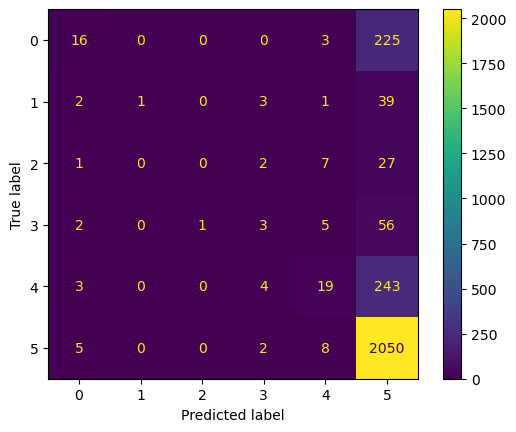

In [70]:
#evaluation
cm = confusion_matrix(testy,lr_pred)
print(f"Accuracy : {accuracy_score(testy,lr_pred)}\n {classification_report(testy,lr_pred)}")
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr.classes_)
cmd.plot()

#### Crossvalidation

In [71]:
print(f"Cross Validation Score : {cross_val_score(lr,train_samples,trainy,cv=5)}")

Cross Validation Score : [0.76535289 0.76626948 0.76626948 0.7652453  0.7652453 ]


#### Hyperparameter Tuning

Accuracy : 0.7752932551319648
               precision    recall  f1-score   support

           0       0.60      0.15      0.24       244
           1       0.64      0.20      0.30        46
           2       0.25      0.05      0.09        37
           3       0.17      0.06      0.09        67
           4       0.43      0.11      0.17       269
           5       0.80      0.99      0.88      2065

    accuracy                           0.78      2728
   macro avg       0.48      0.26      0.29      2728
weighted avg       0.72      0.78      0.71      2728

Best Parameters : {'estimator__C': 5, 'estimator__tol': 0.001}
Best Model : Pipeline(steps=[('f_select',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x17cd4fc40>)),
                ('estimator',
                 LogisticRegression(C=5, max_iter=1000, tol=0.001))])


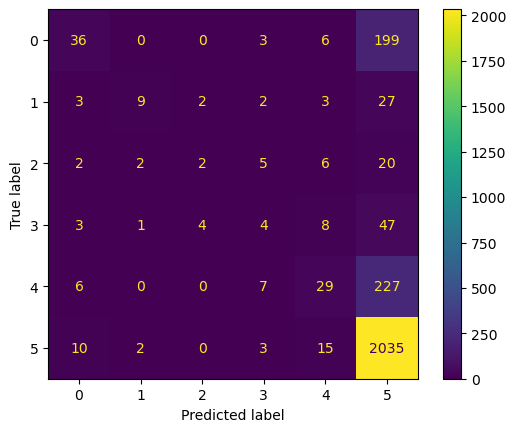

In [72]:
params = {
    'estimator__C': [1,1.5,5,10],
    'estimator__tol': [0.001,0.01,0.0001,0.00001],
}

lr_gsc = GridSearchCV(estimator=lr,param_grid=params,cv=5,scoring='accuracy',n_jobs=-1)

lr_gsc.fit(trainx,trainy)
lr_gsc_pred = lr_gsc.predict(testx)

#evaluation
cm = confusion_matrix(testy,lr_gsc_pred)
print(f"Accuracy : {accuracy_score(testy,lr_gsc_pred)}\n {classification_report(testy,lr_gsc_pred)}")
print(f"Best Parameters : {lr_gsc.best_params_}\nBest Model : {lr_gsc.best_estimator_}")
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr_gsc.classes_)
cmd.plot()

Insights :
* Most values predicted seems to be class 5.
* Using class weights reduced the accuracy score by a big margin
* Best value for C and tol has been found to be 1.5 and 0.001 respectively by hyperparameter tuning.

#### Best LogisticRegression model : Best Model : LogisticRegression(C=1.5, max_iter=1000, tol=0.001)
#### Best Accuracy of LogisticRegression model : 0.781524926686217

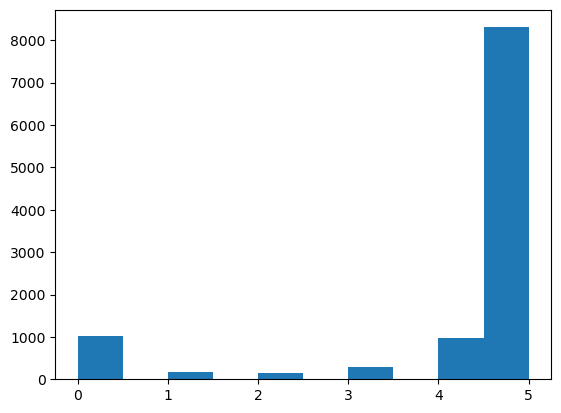

In [73]:
# Checking for class imbalance
# ploting class count
plt.hist(trainy)
plt.show()

* From the above figure it is noticable that a wide majority of the dataset is occupied by the class 5
* As a result the model was not able to learn about the minority class, thus predicting most output as class 5
* One way to resolve this class imbalance is by using oversampling techniques

## another approch

In [83]:
from sklearn.impute import SimpleImputer
skf_si = SimpleImputer(strategy='most_frequent')

Xtrain = skf_si.fit_transform(X['Recipe_Review'].values.reshape(-1,1))[:,0]

from sklearn.feature_extraction.text import TfidfVectorizer
skf_vectorizer = TfidfVectorizer(stop_words=stop_words_list)

Xtrain = skf_vectorizer.fit_transform(Xtrain)


* one way to handle imbalanced data is by oversampling

In [85]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

# xtrain_resampled, ytrain_resampled = SMOTE(random_state=420).fit_resample(skf_xtrain,skf_ytrain)
# print(f"Resampled shape of training datasets - xtrain : {xtrain_resampled.shape} | ytrain : {ytrain_resampled.shape}")

ros = RandomOverSampler(sampling_strategy='auto',random_state=42)
x_resampled, y_resampled = ros.fit_resample(Xtrain,Y)
x_resampled.shape

(62226, 10448)

* RandomOverSampler created a total of 62226 samples.

#### Splitting data using StratifiedKFold
* this helps in spliting the data which would give the best output for a given estimator.

In [86]:
lr_skf = LogisticRegression(random_state=420,max_iter=1000)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,random_state=420,shuffle=True)

skf_scores = []
for train_index,test_index in skf.split(x_resampled,y_resampled):
    skf_xtrain, skf_xtest = x_resampled[train_index], x_resampled[test_index]
    skf_ytrain, skf_ytest = y_resampled[train_index], y_resampled[test_index]
    
    lr_skf.fit(skf_xtrain,skf_ytrain)
    skf_scores.append([lr_skf.score(skf_xtest,skf_ytest),train_index,test_index])

skf_scores

[[0.8949059938936205,
  array([    0,     2,     3, ..., 62223, 62224, 62225]),
  array([    1,    15,    18, ..., 62214, 62220, 62222])],
 [0.8988348734431498,
  array([    1,     2,     3, ..., 62223, 62224, 62225]),
  array([    0,     4,     6, ..., 62212, 62216, 62218])],
 [0.8894335074327039,
  array([    0,     1,     3, ..., 62222, 62224, 62225]),
  array([    2,     5,     8, ..., 62201, 62213, 62223])],
 [0.8949779027721977,
  array([    0,     1,     2, ..., 62223, 62224, 62225]),
  array([   10,    11,    13, ..., 62205, 62206, 62219])],
 [0.8911209321012454,
  array([    0,     1,     2, ..., 62220, 62222, 62223]),
  array([    3,     7,     9, ..., 62221, 62224, 62225])]]

* From the folds, the best obtained accuracy is 0.898272398553636
* split data with those given indices.

In [87]:
print(f" train length : {len(skf_scores[1][1])}, test length : {len(skf_scores[1][2])}")
skf_xtrain = x_resampled[skf_scores[1][1]]
skf_ytrain = y_resampled[skf_scores[1][1]]

skf_xtest = x_resampled[skf_scores[1][2]]
skf_ytest = y_resampled[skf_scores[1][2]]

skf_xtrain

 train length : 49781, test length : 12445


<49781x10448 sparse matrix of type '<class 'numpy.float64'>'
	with 1114034 stored elements in Compressed Sparse Row format>

(array([10371.,     0., 10371.,     0., 10371.,     0., 10371.,     0.,
        10371., 10371.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

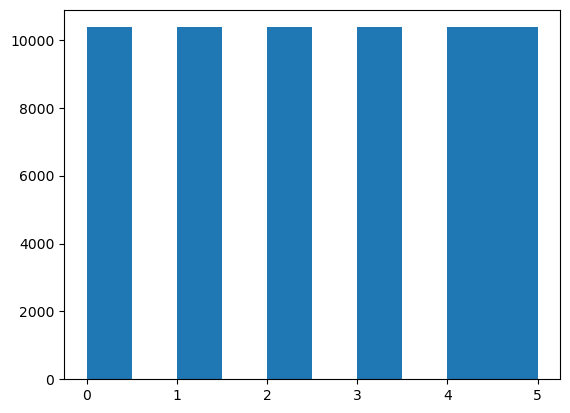

In [88]:
plt.hist(y_resampled)

Accuracy : 0.898754519887505
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      2074
           1       0.98      1.00      0.99      2074
           2       0.99      1.00      0.99      2074
           3       0.94      0.98      0.96      2075
           4       0.84      0.87      0.86      2074
           5       0.80      0.69      0.74      2074

    accuracy                           0.90     12445
   macro avg       0.90      0.90      0.90     12445
weighted avg       0.90      0.90      0.90     12445



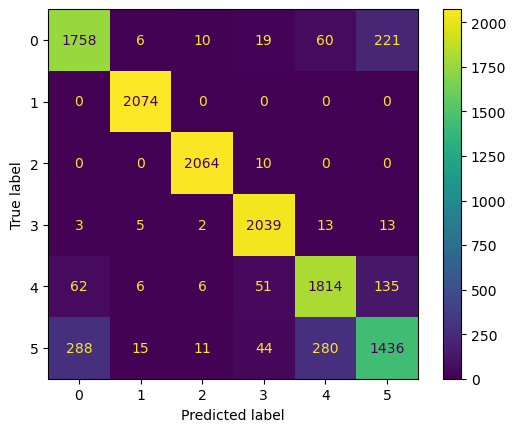

In [89]:
re_lr = LogisticRegression(random_state=420,max_iter=1000,solver='saga')

re_lr.fit(skf_xtrain,skf_ytrain)
re_lr_pred = re_lr.predict(skf_xtest)

cm = confusion_matrix(skf_ytest,re_lr_pred)
print(f"Accuracy : {accuracy_score(skf_ytest,re_lr_pred)}\n {classification_report(skf_ytest,re_lr_pred)}")
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=re_lr.classes_)
cmd.plot()

In [96]:
params = {
    'C': [0.25] ,   #,1.5,2,5],
    'tol': [0.001,0.01,0.0001],    #0.00001]
}

re_lr_gsc = GridSearchCV(estimator=re_lr,param_grid=params,cv=5,scoring='accuracy',n_jobs=-1)

re_lr_gsc.fit(skf_xtrain,skf_ytrain)
re_lr_gsc_pred = re_lr_gsc.predict(skf_xtest)

Accuracy : 0.8422659702691844
               precision    recall  f1-score   support

           0       0.75      0.73      0.74      2074
           1       0.94      1.00      0.97      2074
           2       0.95      0.99      0.97      2074
           3       0.90      0.93      0.91      2075
           4       0.77      0.76      0.77      2074
           5       0.70      0.64      0.67      2074

    accuracy                           0.84     12445
   macro avg       0.84      0.84      0.84     12445
weighted avg       0.84      0.84      0.84     12445

Best Parameters : {'C': 0.25, 'tol': 0.001}
Best Model : LogisticRegression(C=0.25, max_iter=1000, random_state=420, solver='saga',
                   tol=0.001)


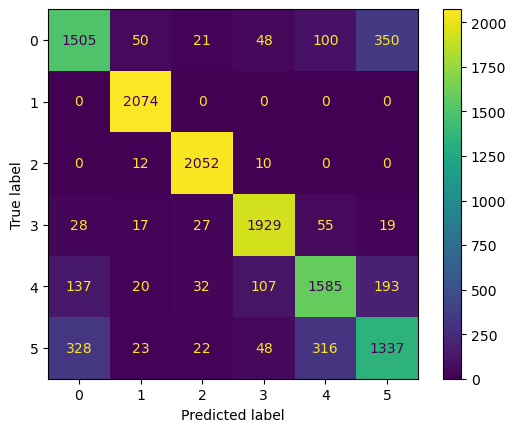

In [97]:
#evaluation
cm = confusion_matrix(skf_ytest,re_lr_gsc_pred)
print(f"Accuracy : {accuracy_score(skf_ytest,re_lr_gsc_pred)}\n {classification_report(skf_ytest,re_lr_gsc_pred)}")
print(f"Best Parameters : {re_lr_gsc.best_params_}\nBest Model : {re_lr_gsc.best_estimator_}")
cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=re_lr_gsc.classes_)
cmd.plot()

* over sampling the data might have created too much noise in the dataset.
* Hence the model might be learning the noise as well.
* this might be a case of overfitting

# 2. DecisionTreeClassifier

In [170]:
# from sklearn.tree import DecisionTreeClassifier

# dtc = DecisionTreeClassifier()
# # criterion='entropy',max_depth=6,splitter='random')
# dtc.fit(trainx, trainy)

# dtc_pred = dtc.predict(testx)
# dtc_pred

array([5, 5, 4, ..., 5, 5, 5])

In [172]:
# #evaluation
# cm = confusion_matrix(testy,dtc_pred)
# print(f"Accuracy : {accuracy_score(testy,dtc_pred)}\n {classification_report(testy,dtc_pred)}")
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtc.classes_)
# cmd.plot()

#### Base accuracy : 0.658357771260997

#### Crossvalidation

In [161]:
# print(f"Cross Validation Score : {cross_val_score(dtc,trainx,trainy,cv=5)}")

Cross Validation Score : [0.75893676 0.76168653 0.75847846 0.75974324 0.75882623]


#### Hyperparameter tuning

In [ ]:
# params = {
#     'max_depth': [5,7,8],
#     'criterion': ['entropy'],
#     'splitter': ['best','random'],
# #     'min_samples_split': [2,3,4],
# #     'min_samples_leaf': [1,2,3]
# }

# dtc_gsc = GridSearchCV(estimator=dtc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)

# dtc_gsc.fit(trainx,trainy)
# dtc_gsc_pred = dtc_gsc.predict(test_samples)

# #evaluation
# cm = confusion_matrix(testy,dtc_gsc_pred)
# print(f"Accuracy : {accuracy_score(testy,dtc_gsc_pred)}\n {classification_report(testy,dtc_gsc_pred)}")
# print(f"Best Parameters : {dtc_gsc.best_params_}\nBest Model : {dtc_gsc.best_estimator_}")
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dtc_gsc.classes_)
# cmd.plot()

# 3. KNeighborsClassifier

In [175]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
    # weights= 'distance',n_neighbors=20,metric='cosine',p=1)
knc.fit(trainx,trainy)

knc_pred = knc.predict(testx)
knc_pred

array([5, 5, 5, ..., 5, 5, 5])

Accuracy : 0.7635630498533724
               precision    recall  f1-score   support

           0       0.53      0.04      0.07       244
           1       0.75      0.07      0.12        46
           2       0.50      0.03      0.05        37
           3       0.27      0.04      0.08        67
           4       0.58      0.03      0.05       269
           5       0.77      1.00      0.87      2065

    accuracy                           0.76      2728
   macro avg       0.57      0.20      0.21      2728
weighted avg       0.71      0.76      0.67      2728



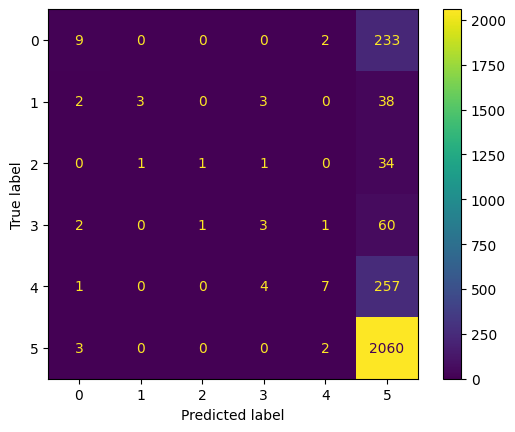

In [176]:
# #evaluation
# cm = confusion_matrix(testy,knc_pred)
# print(f"Accuracy : {accuracy_score(testy,knc_pred)}\n {classification_report(testy,knc_pred)}")
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knc.classes_)
# cmd.plot()
# plt.show()

#### Base accuracy : 0.17082111436950145

#### Crossvalidation

In [ ]:
# print(f"Cross Validation Score : {cross_val_score(knc,trainx,trainy,cv=5)}")

#### Hyperparameter tuning

In [ ]:
# params = {
# #     'n_neighbors': [10,20,30],
# #     'weights': ['uniform','distance']
#     'p': [1,2,3],
#     'leaf_size': [20,10]
# #     'metric': ['cityblock','euclidean','cosine','manhattan']
# }

# knc_gsc = GridSearchCV(estimator=knc,param_grid=params,cv=3,scoring='accuracy',n_jobs=-1)

# knc_gsc.fit(trainx,trainy)
# knc_gsc_pred = knc_gsc.predict(testx)

# #evaluation
# cm = confusion_matrix(testy,knc_gsc_pred)
# print(f"Accuracy : {accuracy_score(testy,knc_gsc_pred)}\n {classification_report(testy,knc_gsc_pred)}")
# print(f"Best Parameters : {knc_gsc.best_params_}\nBest Model : {knc_gsc.best_estimator_}")
# cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knc_gsc.classes_)
# cmd.plot()
# plt.show()

# SUBMISSION

In [103]:
Xtest = test['Recipe_Review']

Xtest = si.fit_transform(Xtest.values.reshape(-1,1))[:,0]

Xtest = skf_vectorizer.transform(Xtest)

In [104]:
y_pred = re_lr_gsc.best_estimator_.predict(Xtest)

submission = pd.DataFrame({'ID': range(1,4547),
                          'Rating': y_pred})

submission.to_csv('submission.csv',index=False)
print("Submission Succesful")

Submission Succesful
